# Produce Mock data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton

# Kepler equation solver (numerically)
def kepler_E(M, e, tol=1e-10):
    func = lambda E: E - e*np.sin(E) - M # lambda is a keyword: basically in this line I am defining residual  def func(E):return E - e*np.sin(E) - M
    E0 = M if e < 0.8 else np.pi         # Just for better convergence
    return newton(func, E0)              # I am using newton function from scipy.optimize instead of numerically doing it

# Orbit model
def orbit_model(t, theta):                                                     # Returns RA, Dec, and radial velocity as a function of time 𝑡 and orbital parameters
    a, e, i_deg, omega_deg, Omega_deg, T0, Mtot = theta                        # a in AU, M in solar mass,
    i = np.radians(i_deg) # inclination 
    omega = np.radians(omega_deg) # argument of periastron
    Omega = np.radians(Omega_deg) # longitude of ascending node

    # now orbital period and mean motion
    P = np.sqrt(a**3 / Mtot)  # Kepler's third law -  P in years
    n = 2*np.pi / P           # mean motion = 2π/P
    
    RA_list, Dec_list, RV_list = [], [], []

    # Loop over each observation time
    for t_i in t:
        M_anom = n * (t_i - T0) % (2*np.pi)                                   # Mean anomaly
        E = kepler_E(M_anom, e)                                               # eccentric anomaly obtained after solving Kepler’s equation
        f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))  # True anomaly and distance to central body in orbital plane (AU)
        r = a * (1 - e*np.cos(E))
        
        x_orb = r*np.cos(f)                                                   # Position in the orbital plane
        y_orb = r*np.sin(f)
        z_orb = 0

        # Project to sky plane using standard rotation matrix 
        # X,Y are projected position in AU
        
        X = ( np.cos(Omega)*np.cos(omega) - np.sin(Omega)*np.sin(omega)*np.cos(i) )*x_orb + \
            ( -np.cos(Omega)*np.sin(omega) - np.sin(Omega)*np.cos(omega)*np.cos(i) )*y_orb
        Y = ( np.sin(Omega)*np.cos(omega) + np.cos(Omega)*np.sin(omega)*np.cos(i) )*x_orb + \
            ( -np.sin(Omega)*np.sin(omega) + np.cos(Omega)*np.cos(omega)*np.cos(i) )*y_orb
        Z = ( np.sin(omega)*np.sin(i) )*x_orb + ( np.cos(omega)*np.sin(i) )*y_orb
        
        RA_list.append(X)
        Dec_list.append(Y)
        
        K = (2*np.pi*a*np.sin(i)) / (P*np.sqrt(1 - e**2))                          # RADIAL VELOCITY
        RV = K * (np.cos(f + omega) + e*np.cos(omega))
        RV_list.append(RV)
    
    return np.array(RA_list), np.array(Dec_list), np.array(RV_list) 

# Generate random data
np.random.seed(42)
# with the following parameters

theta = [2.0, 0.88, 45, 120, 60, 0, 5.0]  

# Random observation times over ~2 periods.
t_min = 0
t_max = 2 * np.sqrt(theta[0]**3 / theta[6])
t_random = np.random.uniform(t_min, t_max, 150)

RA, Dec, RV = orbit_model(t_random, theta)

# Add Gaussian noise
RA_obs = RA + np.random.normal(0, 0.01, size=RA.shape)
Dec_obs = Dec + np.random.normal(0, 0.01, size=Dec.shape)

df = pd.DataFrame({
    'time': t_random,
    'RA_obs': RA_obs,
    'Dec_obs': Dec_obs,
    'RA_err': 0.1,
    'Dec_err': 0.1
}).sort_values(by='time').reset_index(drop=True)

# Save to CSV
csv_path = 'simulated_orbit_data.csv'
df.to_csv(csv_path, index=False)

csv_path


# We have skipped the parameters of the central black hole. The most important one is the distance to the black hole.
# Here RA & Dec output are still in AU on the plane of the sky, not in observable angular units (like arcseconds).
# To include the distance D, (say D=10 kpc), after computing, X,Y, we need to convert to angular units, by dividing them by D


'simulated_orbit_data.csv'

In [2]:
# Assuming orbit_model and kepler_E from earlier are already defined

np.random.seed(43)

# Define orbital parameters again for clarity
theta = [2.0, 0.88, 45, 120, 60, 0, 5.0]

t_min = 0
t_max = 2 * np.sqrt(theta[0]**3 / theta[6])

# Generate random times for RV data
t_rv_random = np.random.uniform(t_min, t_max, 50)

# Compute RA, Dec, RV
_, _, RV = orbit_model(t_rv_random, theta)

# Add Gaussian noise
RV_obs = RV + np.random.normal(0, 0.5, size=RV.shape)  # noise ~0.5
RV_err = np.full_like(RV_obs, 0.5)

# Create dataframe
df_rv = pd.DataFrame({
    'time': t_rv_random,
    'RV_obs': RV_obs,
    'RV_err': RV_err
}).sort_values(by='time').reset_index(drop=True)

# Save to CSV
df_rv.to_csv('simulated_rv_data.csv', index=False)
print("RV data saved to simulated_rv_data.csv")


RV data saved to simulated_rv_data.csv


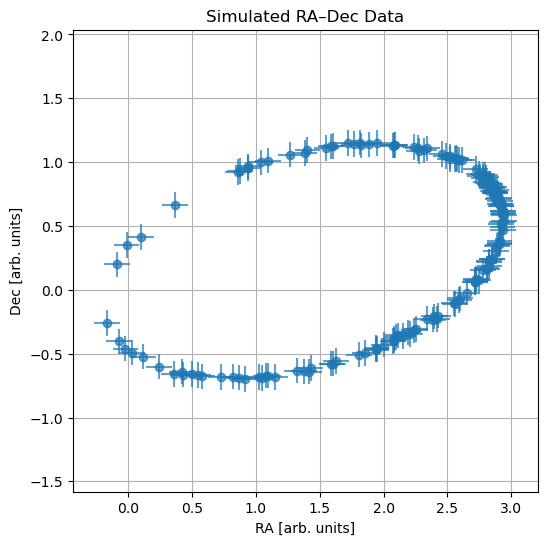

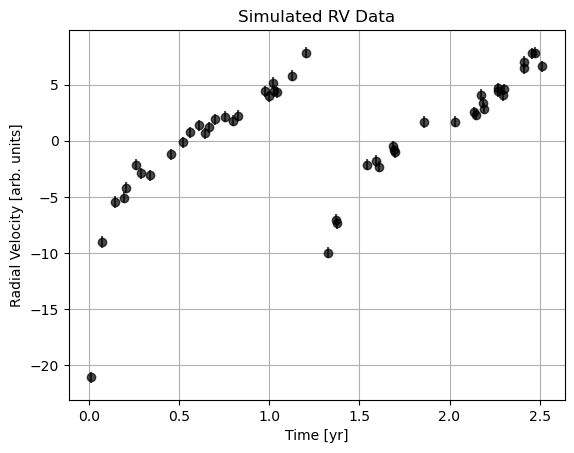

In [2]:
# Load position data (from earlier step)
df_pos = pd.read_csv(r"C:\Users\PÓS-DOC-01\Downloads\GRASP\simulated_orbit_data.csv")

# Plot RA–Dec
plt.figure(figsize=(6,6))
plt.errorbar(df_pos['RA_obs'], df_pos['Dec_obs'], 
             xerr=df_pos['RA_err'], yerr=df_pos['Dec_err'],
             fmt='o', alpha=0.7)
plt.xlabel('RA [arb. units]')
plt.ylabel('Dec [arb. units]')
plt.title('Simulated RA–Dec Data')
plt.grid()
plt.axis('equal')
plt.show()

# Plot RV vs time
plt.figure()
plt.errorbar(df_rv['time'], df_rv['RV_obs'], yerr=df_rv['RV_err'], fmt='ko', alpha=0.7)
plt.xlabel('Time [yr]')
plt.ylabel('Radial Velocity [arb. units]')
plt.title('Simulated RV Data')
plt.grid()
plt.show()


# MCMC

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import newton
import emcee
import matplotlib.pyplot as plt
import corner

# Load the data which you just simulated

df_pos = pd.read_csv("simulated_orbit_data.csv")
df_rv = pd.read_csv("simulated_rv_data.csv")

t_obs = np.concatenate([df_pos['time'], df_rv['time']])
RA_obs = df_pos['RA_obs']
Dec_obs = df_pos['Dec_obs']
RV_obs = df_rv['RV_obs']

sigma_RA = df_pos['RA_err']
sigma_Dec = df_pos['Dec_err']
sigma_RV = df_rv['RV_err']


In [4]:
# Now we build the statistical model 
# On the theory side we need to define the orbit model 

def kepler_E(M, e, tol=1e-10): # same old keppler
    func = lambda E: E - e*np.sin(E) - M
    E0 = M if e < 0.8 else np.pi
    return newton(func, E0)


def orbit_model(t, theta): # this is the important function. It produces an orbit (output RA and Dec from the theory) for given family of paramter values (selected form our prior range)
    a, e, i_deg, omega_deg, Omega_deg, T0, Mtot = theta
    i = np.radians(i_deg)
    omega = np.radians(omega_deg)
    Omega = np.radians(Omega_deg)

    P = np.sqrt(a**3 / Mtot)
    n = 2*np.pi / P

    RA_model, Dec_model, RV_model = [], [], []

    for t_i in t:
        M_anom = n * (t_i - T0) % (2*np.pi)
        E = kepler_E(M_anom, e)
        f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))
        r = a * (1 - e*np.cos(E))

        x_orb = r*np.cos(f)
        y_orb = r*np.sin(f)

        X = ( np.cos(Omega)*np.cos(omega) - np.sin(Omega)*np.sin(omega)*np.cos(i) )*x_orb + \
            ( -np.cos(Omega)*np.sin(omega) - np.sin(Omega)*np.cos(omega)*np.cos(i) )*y_orb
        Y = ( np.sin(Omega)*np.cos(omega) + np.cos(Omega)*np.sin(omega)*np.cos(i) )*x_orb + \
            ( -np.sin(Omega)*np.sin(omega) + np.cos(Omega)*np.cos(omega)*np.cos(i) )*y_orb
        Z = ( np.sin(omega)*np.sin(i) )*x_orb + ( np.cos(omega)*np.sin(i) )*y_orb

        RA_model.append(X)
        Dec_model.append(Y)

        K = (2*np.pi*a*np.sin(i)) / (P*np.sqrt(1 - e**2))
        RV = K * (np.cos(f + omega) + e*np.cos(omega))
        RV_model.append(RV)

    return np.array(RA_model[:len(RA_obs)]), np.array(Dec_model[:len(Dec_obs)]), np.array(RV_model[len(RA_obs):])

# Likelihood
def log_likelihood(theta):
    RA_mod, Dec_mod, RV_mod = orbit_model(t_obs, theta)
    chi2_RA = np.sum( ((RA_mod - RA_obs) / sigma_RA)**2 )
    chi2_Dec = np.sum( ((Dec_mod - Dec_obs) / sigma_Dec)**2 )
    chi2_RV = np.sum( ((RV_mod - RV_obs) / sigma_RV)**2 )
    return -0.5 * (chi2_RA + chi2_Dec + chi2_RV)

# Priors
def log_prior(theta):
    a, e, i, omega, Omega, T0, M = theta
    if not (0.8 < e < 0.9 and 1.5 < a < 2.5 and 40 < i < 50, 118 < omega < 122, 55 < Omega < 65, -0.01< T0 < 0.01, 4.5 < M < 5.5):
        return -np.inf
    return 0.0

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# Running MCMC
ndim = 7
nwalkers = 50
nsteps = 5000

initial = np.array([2, 0.85, 42, 119, 58, 0, 4.8])   # initial guess of parameters
pos = initial + 1e-7*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True) # Runs each walker for nsteps iterations.

samples = sampler.get_chain(flat=True) # A 2D array of shape (nsteps * nwalkers, ndim) containing all sampled parameter values.

Running MCMC...


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:26:22<00:00,  2.48s/it]


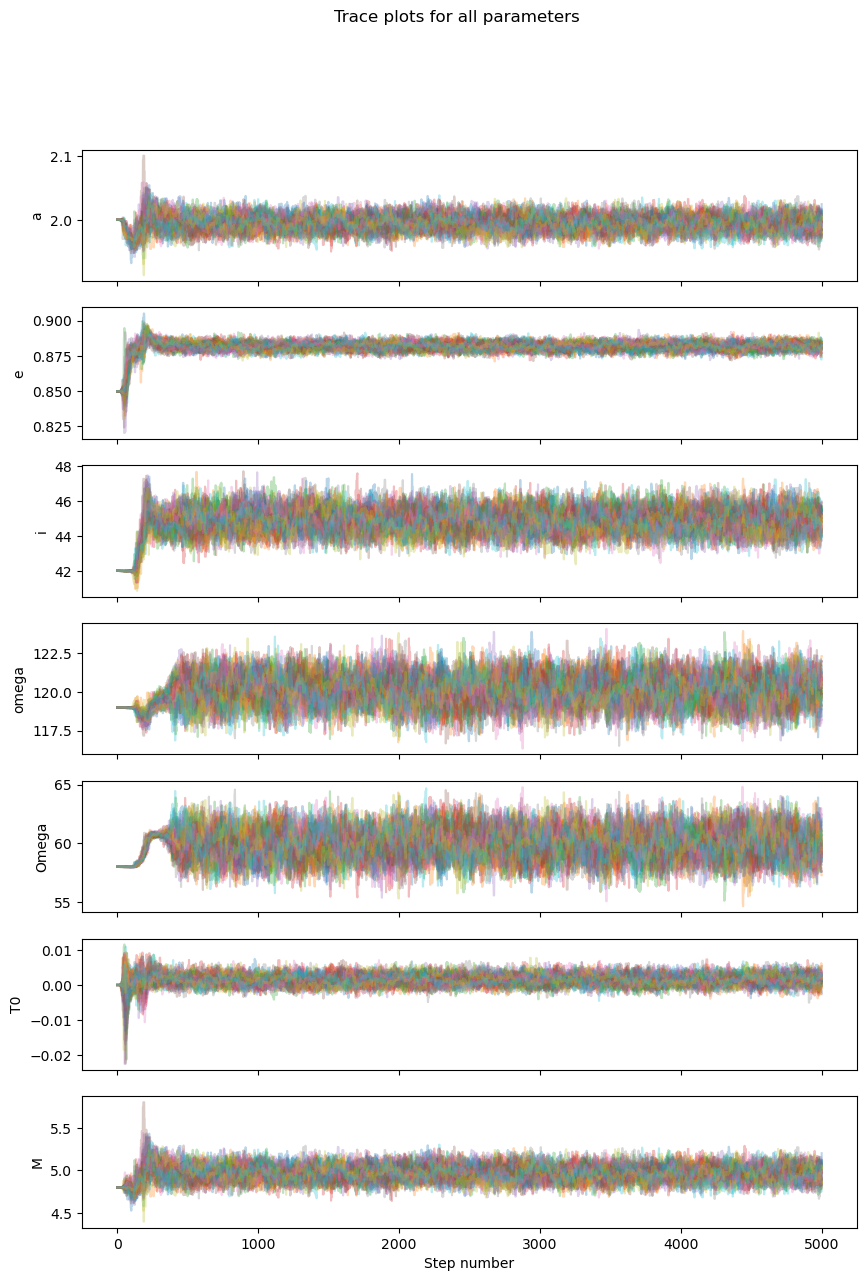

In [5]:
import matplotlib.pyplot as plt
# convergence plots

samples_all = sampler.get_chain()  # shape (nsteps, nwalkers, ndim)
param_names = ["a", "e", "i", "omega", "Omega", "T0", "M"]

fig, axes = plt.subplots(ndim, 1, figsize=(10, 2*ndim), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(nwalkers):
        ax.plot(samples_all[:, walker, i], alpha=0.3)
    ax.set_ylabel(param_names[i])
axes[-1].set_xlabel("Step number")
plt.suptitle("Trace plots for all parameters")
plt.show()


In [6]:
# mean and per-walker acceptance fractions
af = sampler.acceptance_fraction
print(f"Mean acceptance fraction: {np.mean(af):.3f}")
print("Acceptance fractions per walker:")
print(af)


Mean acceptance fraction: 0.486
Acceptance fractions per walker:
[0.4854 0.489  0.4848 0.4802 0.484  0.4922 0.4894 0.4868 0.4774 0.481
 0.4876 0.489  0.487  0.483  0.465  0.4862 0.504  0.4934 0.4818 0.498
 0.4852 0.5052 0.4872 0.4876 0.4912 0.4962 0.4784 0.4768 0.4982 0.4824
 0.488  0.4816 0.4762 0.4904 0.4928 0.5042 0.4788 0.4872 0.4816 0.4742
 0.4786 0.4838 0.4878 0.49   0.4906 0.4738 0.4812 0.496  0.4918 0.4806]


In [7]:
try:
    tau = sampler.get_autocorr_time()
    print("Autocorrelation times (per parameter):")
    for name, t in zip(["a", "e", "i", "omega", "Omega", "T0", "M"], tau):
        print(f"{name:7s} : {t:.1f} steps")
except Exception as e:
    print("Could not compute autocorrelation times yet — chains may be too short.")
    print(e)


Could not compute autocorrelation times yet — chains may be too short.
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 61.50137149  66.38780768 114.41002721 103.17837725  72.15106251
  65.4254718   65.24735688]


Autocorrelation times: [ 61.50137149  66.38780768 114.41002721 103.17837725  72.15106251
  65.4254718   65.24735688]


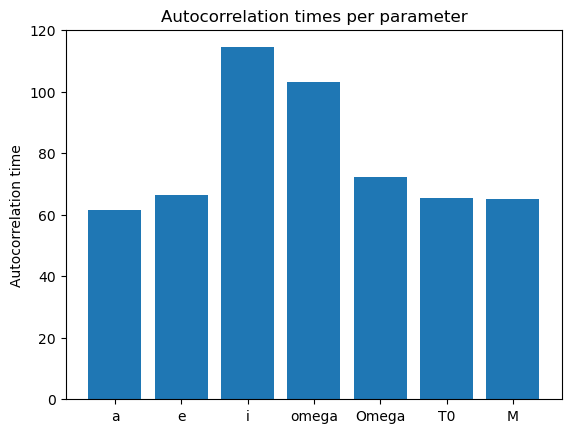

In [8]:
tau = sampler.get_autocorr_time(tol=0)
print("Autocorrelation times:", tau)

fig, ax = plt.subplots()
ax.bar(param_names, tau)
ax.set_ylabel("Autocorrelation time")
ax.set_title("Autocorrelation times per parameter")
plt.show()


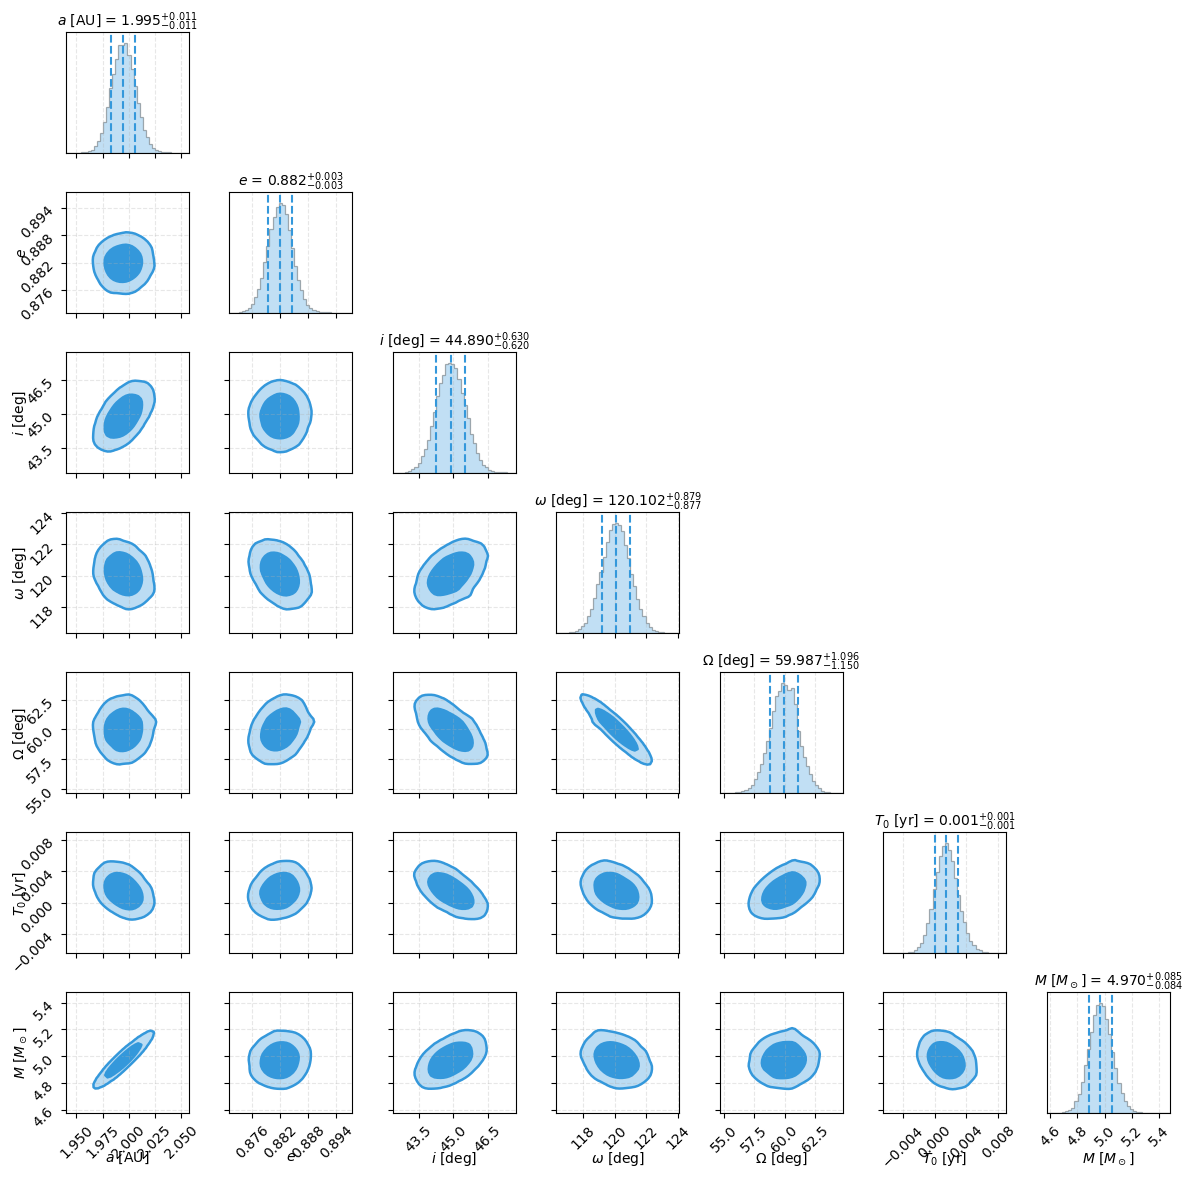

In [9]:
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set up professional styling
mpl.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# Burn the first 1000 samples
burn_in = 10000
post_burn_samples = samples[burn_in:]


# Parameter labels with units
labels = [
    r"$a$ [AU]", 
    r"$e$", 
    r"$i$ [deg]", 
    r"$\omega$ [deg]", 
    r"$\Omega$ [deg]", 
    r"$T_0$ [yr]", 
    r"$M$ [$M_\odot$]"
]

# Create the corner plot with professional settings
fig = corner.corner(
    post_burn_samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  # Median and ±1σ
    show_titles=True,
    title_fmt='.3f',  # 3 decimal places
    title_kwargs={"fontsize": 10, "pad": 5},
    label_kwargs={"fontsize": 10},
    color="#3498db",  # Professional blue
    smooth=1.0,      # Smoother distributions
    bins=40,         # More bins for better resolution
    plot_datapoints=False,
    fill_contours=True,
    levels=[0.68, 0.95],  # 1σ and 2σ contours
    hist_kwargs={
        "density": True,
        "edgecolor": "k",
        "linewidth": 0.9,
        "histtype": "stepfilled",
        "alpha": 0.3
    },
    contour_kwargs={
        "linewidths": 1.8,
        "linestyles": "solid"
    },
    fig=plt.figure(figsize=(12, 12)))  # Larger figure size

# Adjust layout
plt.tight_layout(pad=1.0)  # Extra padding
plt.show()